In [1]:
#default_exp prefect_flows.step1

In [2]:
#export

import os #hi
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, dictconfig
from hydra.core.hydra_config import HydraConfig
from fastcore.basics import partialler
import pandas as pd
from pydantic import BaseModel
from typing import Optional, List
import numpy as np
from pathlib import Path
from dataclasses import dataclass

In [3]:
#export

from prefect import Task, Flow, task, Parameter, context, case, unmapped
from prefect.engine.results import LocalResult
from prefect.engine.serializers import PandasSerializer
from prefect.engine import signals
from prefect.tasks.control_flow import merge
from prefect.tasks.prefect import create_flow_run, RenameFlowRun
from prefect.tasks.templates import StringFormatter
context.config.flows.checkpointing = True

In [4]:
#export

from corradin_ovp_utils.datasets.CombinedGenoPheno import CombinedGenoPheno
from corradin_ovp_utils.catalog import get_catalog, test_data_catalog, get_config
from corradin_ovp_utils.odds_ratio import odds_ratio_df_single_combined
from corradin_ovp_utils.MTC import MtcTable
from corradin_ovp_utils.datasets.utils import cd
from corradin_ovp_utils.catalog import change_cwd_dir, package_outer_folder

---

In [65]:
#export

class SNPPairInfo(BaseModel):
    GWAS_id: str
    outside_id: str
    GWAS_chrom: int
    outside_chrom: int
    mtc_threshold: float = None

In [66]:
#export
tsv_result_partial = partialler(LocalResult, dir="./prefect_step1_result_folder", serializer = PandasSerializer("csv",
                                                                         serialize_kwargs={"sep":"\t", "index": False},
                                                                         deserialize_kwargs={"sep": "\t"}))

parquet_result_partial = partialler(LocalResult, dir="./prefect_step1_result_folder", serializer = PandasSerializer("parquet"))
ID_COL_LIST = ["rsid", "position"]
ALL_GENO_DF_FILE_NAME = "all_geno_df.parquet"
ALL_SAMPLES_GENO_DF_FILE_NAME = "all_samples_geno_df.parquet"
SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME = partialler("{subset}_{ALL_SAMPLES_GENO_DF_FILE_NAME}".format, ALL_SAMPLES_GENO_DF_FILE_NAME = ALL_SAMPLES_GENO_DF_FILE_NAME)
SAMPLE_SUBSETS= ["case", "control"]
SEARCH_RESULT_DF_FILE_NAME = "snp_search_result.tsv"
UNFILTERED_SUMMARY_DF_FILE_NAME = "all_pairs_summary_df_unfiltered.tsv"
STEP1_FINAL_REPORT_FILE_NAME = "step1_final_report.tsv"
SINGLE_PAIR_DATA_CACHE_TEMPLATE_WITHOUT_EXTENSION = "snp_pairs_folders/{GWAS_id}/{GWAS_id}_{outside_id}/single_pair_data_cache_df"

def format_result_dir(cfg, task_name, **kwargs):
    return f"{Path(cfg.hydra.run.dir)}/{task_name}"

task_no_checkpoint = partialler(task, checkpoint=False)

@task_no_checkpoint
def get_datasets(*,env:str, genetic_dataset_name:str, sample_dataset_name:str):
    catalog = get_catalog(env=env, patterns = ['catalog*', 'catalog*/*/','catalog*/*/*'])
    genetic =  catalog.load(genetic_dataset_name)
    sample = catalog.load(sample_dataset_name)
    return dict(catalog=catalog, genetic_dataset=genetic, sample_dataset=sample)
    #return catalog, genetic, sample

@task_no_checkpoint
#@task(target= "run_config.pkl")
def get_config_task(*, pairs_file:str, config_path:str,  overrides: List[str]=[], config_name:str = "config"):
#     hydra_cfg_raw = dictconfig.DictConfig({"hydra": {'run': {'dir': 'outputs/${dataset.genetic}/${exp}/${pairs_file}/${now:%Y-%m-%d}/${now:%H-%M-%S}'},
#                                                         'sweep': {'dir': 'multirun/${now:%Y-%m-%d}/${now:%H-%M-%S}', 'subdir': '${hydra.job.num}'},
#                                                         'launcher': {'_target_': 'hydra._internal.core_plugins.basic_launcher.BasicLauncher'},
#                                                         'sweeper': {'_target_': 'hydra._internal.core_plugins.basic_sweeper.BasicSweeper', 'max_batch_size': None}, 'help': {'app_name': '${hydra.job.name}', 'header': '${hydra.help.app_name} is powered by Hydra.\n', 'footer': 'Powered by Hydra (https://hydra.cc)\nUse --hydra-help to view Hydra specific help\n', 'template': '${hydra.help.header}\n== Configuration groups ==\nCompose your configuration from those groups (group=option)\n\n$APP_CONFIG_GROUPS\n\n== Config ==\nOverride anything in the config (foo.bar=value)\n\n$CONFIG\n\n${hydra.help.footer}\n'}, 'hydra_help': {'template': "Hydra (${hydra.runtime.version})\nSee https://hydra.cc for more info.\n\n== Flags ==\n$FLAGS_HELP\n\n== Configuration groups ==\nCompose your configuration from those groups (For example, append hydra/job_logging=disabled to command line)\n\n$HYDRA_CONFIG_GROUPS\n\nUse '--cfg hydra' to Show the Hydra config.\n", 'hydra_help': '???'}, 'hydra_logging': {'version': 1, 'formatters': {'simple': {'format': '[%(asctime)s][HYDRA] %(message)s'}}, 'handlers': {'console': {'class': 'logging.StreamHandler', 'formatter': 'simple', 'stream': 'ext://sys.stdout'}}, 'root': {'level': 'INFO', 'handlers': ['console']}, 'loggers': {'logging_example': {'level': 'DEBUG'}}, 'disable_existing_loggers': False}, 'job_logging': {'version': 1, 'formatters': {'simple': {'format': '[%(asctime)s][%(name)s][%(levelname)s] - %(message)s'}}, 'handlers': {'console': {'class': 'logging.StreamHandler', 'formatter': 'simple', 'stream': 'ext://sys.stdout'}, 'file': {'class': 'logging.FileHandler', 'formatter': 'simple', 'filename': '${hydra.job.name}.log'}}, 'root': {'level': 'INFO', 'handlers': ['console', 'file']}, 'disable_existing_loggers': False}, 'env': {}, 'searchpath': [], 'callbacks': {}, 'output_subdir': '.hydra', 'overrides': {'hydra': [], 'task': ['exp=test', 'pairs_file=test_file']}, 'job': {'name': 'hydra_test', 'override_dirname': 'exp=test,pairs_file=test_file', 'id': '???', 'num': '???', 'config_name': 'config', 'env_set': {}, 'env_copy': [], 'config': {'override_dirname': {'kv_sep': '=', 'item_sep': ',', 'exclude_keys': []}}}, 'runtime': {'version': '1.1.0', 'cwd': '/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils', 'config_sources': [{'path': 'hydra.conf', 'schema': 'pkg', 'provider': 'hydra'}, {'path': '/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/conf/hydra_conf', 'schema': 'file', 'provider': 'main'}, {'path': '', 'schema': 'structured', 'provider': 'schema'}], 'choices': {'run': 'default', 'hydra': 'default', 'dataset': 'MS', 'db': 'mysql', 'hydra/env': 'default', 'hydra/callbacks': None, 'hydra/job_logging': 'default', 'hydra/hydra_logging': 'default', 'hydra/hydra_help': 'default', 'hydra/help': 'default', 'hydra/sweeper': 'basic', 'hydra/launcher': 'basic', 'hydra/output': 'default'}}, 'verbose': False}})
    #TODO: add hydra configs here
    hydra_cfg_raw = {}

    if Path(config_path).is_absolute():
        with initialize_config_dir(config_dir=config_path):
            cfg_job = compose(config_name = config_name, overrides=overrides)
    else:
        with initialize(config_path=config_path):
            cfg_job = compose(config_name = config_name, overrides=overrides)

    cfg = OmegaConf.merge(hydra_cfg_raw, cfg_job)
    cfg.pairs_file = pairs_file
    return cfg


@task_no_checkpoint(skip_on_upstream_skip=False)
def process_pairs_file(*, pairs_file):
    pairs_df = pd.read_csv(pairs_file, sep = "\t")
    GWAS_dict = pairs_df.groupby("GWAS_chrom")["GWAS_id"].unique().to_dict()
    outside_dict = pairs_df.groupby("outside_chrom")["outside_id"].unique().to_dict()
    all_keys = list(GWAS_dict.keys()) + list(outside_dict.keys())
    chr_to_snp_dict = {}
    for key in all_keys:
        GWAS_dict_vals = GWAS_dict.get(key, [])
        outside_dict_vals = outside_dict.get(key, [])
        merged = np.append(GWAS_dict_vals,outside_dict_vals)
        chr_to_snp_dict[key] = merged
    return {"pairs_df": pairs_df, "chr_to_snp_dict": chr_to_snp_dict}

#TODO: Map this across chromosomes
@task_no_checkpoint#(target="{task_name}.pkl", checkpoint=True)
def get_snps_info(*, genetic_dataset, sample_dataset, chr_to_snp_dict):

#     sample_subset_files_list = [SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME(subset = subset) for subset in SAMPLE_SUBSETS]#combined_geno.sample_subsets}

#     file_names_to_check = [ALL_GENO_DF_FILE_NAME, ALL_SAMPLES_GENO_DF_FILE_NAME] + sample_subset_files_list
#     file_exist_cond_list = [parquet_result_partial().exists(location=file_name) for file_name in file_names_to_check]

#     if all(file_exist_cond_list):
#         raise signals.SKIP(message=f"Found existing {ALL_GENO_DF_FILE_NAME} and {ALL_SAMPLES_GENO_DF_FILE_NAME} in {parquet_result_partial().dir}, skipping reading genetic data")
#         return
#     else:
    combined_geno = CombinedGenoPheno.init_from_OVPDataset(genetic_dataset= genetic_dataset,
                                  sample_dataset=sample_dataset,
                                  rsid_dict=chr_to_snp_dict,
                                  id_col_list = ID_COL_LIST)

    #parquet_result.write(combined_geno.all_geno_df, location = all_geno_df_file_name, target = all_geno_df_file_name,  **context,)
    #parquet_result.write(combined_geno.all_samples_geno_df, location = all_samples_geno_df_file_name, target = all_geno_df_file_name, **context)


    parquet_result_partial(location=ALL_GENO_DF_FILE_NAME).write(combined_geno.all_geno_df, **context)
    parquet_result_partial(location=ALL_SAMPLES_GENO_DF_FILE_NAME).write(combined_geno.all_samples_geno_df, **context)

#         sample_subset_files_dict = {SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME(subset = subset) : combined_geno.get_geno_each_sample_subset(subset) for subset in SAMPLE_SUBSETS}

    # for file_name, subset_geno_df in sample_subset_files_dict.items():
    #     parquet_result_partial(location=file_name).write(subset_geno_df, **context)

    return {"all_geno_df":combined_geno.all_geno_df,
            "all_samples_geno_df": combined_geno.all_samples_geno_df}

@task_no_checkpoint(target=SEARCH_RESULT_DF_FILE_NAME, checkpoint=True, result = tsv_result_partial(), skip_on_upstream_skip=False)
def output_search_result_df(pairs_df):
    all_geno_df = parquet_result_partial().read(location=ALL_GENO_DF_FILE_NAME).value
    search_result_df = pd.melt(pairs_df, id_vars=["GWAS_chrom", "outside_chrom"], value_name = "SNP_ID", var_name = "SNP_type").drop_duplicates("SNP_ID")
    search_result_df["chrom"] = np.where(search_result_df["SNP_type"] == "GWAS_id", search_result_df["GWAS_chrom"], search_result_df["outside_chrom"])
    search_result_df = search_result_df.drop(columns = ["GWAS_chrom", "outside_chrom"])
    search_result_df = search_result_df.merge(all_geno_df,
                                left_on = "SNP_ID",
                                right_index=True,
                                how="outer",
                                indicator=True).replace({"both": 1, "left_only": "0"}).rename(columns = {"_merge": "found_in_genetic_file"})[["chrom", "SNP_type", "SNP_ID", "found_in_genetic_file"]]
    return search_result_df

@task_no_checkpoint
def load_extracted_info(*, all_geno_df_file_name:str, search_result_df_file_name:str):
    search_result_df = tsv_result_partial().read(location = SEARCH_RESULT_DF_FILE_NAME).value
    all_geno_df = parquet_result_partial().read(location = ALL_GENO_DF_FILE_NAME)


@task_no_checkpoint#(skip_on_upstream_skip=False)
def pairs_df_to_records(pairs_df, search_result_df=None, mtc_df=None):
    if search_result_df is not None:
        found_SNPs = search_result_df.query("found_in_genetic_file == 1").SNP_ID.tolist()
        found_pairs_df = pairs_df.query("GWAS_id in @found_SNPs and outside_id in @found_SNPs")
    else:
        found_pairs_df = pairs_df

    found_pairs_df = found_pairs_df.drop_duplicates(subset = ["GWAS_id", "outside_id", "GWAS_chrom", "outside_chrom"])

    if mtc_df is not None:
        found_pairs_df = found_pairs_df.merge(mtc_df[["GWAS_id"]], how = "inner")
        mtc_table = MtcTable(mtc_df, "threshold")
        snp_pair_info_list = [SNPPairInfo(**pair, mtc_threshold= mtc_table.get_threshold(pair["GWAS_id"])) for pair in found_pairs_df.to_dict(orient="records")]
    else:
        snp_pair_info_list = [SNPPairInfo(**pair) for pair in found_pairs_df.to_dict(orient="records")]

    return snp_pair_info_list

def template_summary_df_target(*, pair_info: SNPPairInfo, parquet=False, **kwargs):
    GWAS_id = pair_info.GWAS_id
    outside_id = pair_info.outside_id

    if parquet:
        final_template = SINGLE_PAIR_DATA_CACHE_TEMPLATE_WITHOUT_EXTENSION + ".parquet"
    else:
        final_template = SINGLE_PAIR_DATA_CACHE_TEMPLATE_WITHOUT_EXTENSION + ".tsv"

    return final_template.format(GWAS_id = GWAS_id, outside_id = outside_id)

@task_no_checkpoint
def get_sample_subset_id_dict(sample_dataset):
    sample_subset_id_dict = {}
    sample_dataset_files_dict = vars(sample_dataset.files)
    if "single_file" in sample_dataset_files_dict:
        sample_subset_id_dict["case"] = sample_dataset_files_dict["single_file"].load(with_missing_samples=False, subset = "case").index.values.astype(str)
        sample_subset_id_dict["control"] = sample_dataset_files_dict["single_file"].load(with_missing_samples=False, subset = "control").index.values.astype(str)
    else:
        sample_subset_id_dict["case"] = sample_dataset_files_dict["case"].load(with_missing_samples=False).index.values.astype(str)
        sample_subset_id_dict["control"] = sample_dataset_files_dict["control"].load(with_missing_samples=False).index.values.astype(str)

    return sample_subset_id_dict

@task_no_checkpoint(target=template_summary_df_target,
      checkpoint=True,
      result = tsv_result_partial(),
      #skip_on_upstream_skip=False,
      task_run_name = "extract_info_{pair_info.GWAS_id}_{pair_info.outside_id}",
      name = "Output df for each single pair")
#@task(skip_on_upstream_skip=False)
def output_case_control_single_pair_data_cache_df(pair_info, sample_subset_id_dict):
    all_geno_df = parquet_result_partial().read(location=ALL_GENO_DF_FILE_NAME).value

#     if "single_file" in shared_keys:
#         sample_dict_loaded["case"] =  sample_dict[key].load(with_missing_samples = False, subset = "case")
#         sample_dict_loaded["control"] =

    GWAS_id = pair_info.GWAS_id
    outside_id = pair_info.outside_id

    #load only the info of the 2 SNPs
    parquet_column_subset_result = LocalResult(dir="./prefect_step1_result_folder",
                                               serializer = PandasSerializer("parquet", deserialize_kwargs={"columns": [GWAS_id, outside_id]}))

    all_samples_geno_df = parquet_column_subset_result.read(location = ALL_SAMPLES_GENO_DF_FILE_NAME).value

    not_found_case = set(sample_subset_id_dict["case"]) - set(all_samples_geno_df.index)
    not_found_control = set(sample_subset_id_dict["control"]) - set(all_samples_geno_df.index)

    #check to see if the samples in the genetic data are found in the sample file
    #if this assertion is wrong maybe you're rerunning the code on files created from a different dataset than your argument
    assert len(not_found_case) < 100 and len(not_found_control) < 100

    cases_found = sample_subset_id_dict["case"][~np.isin(sample_subset_id_dict["case"], list(not_found_case))]
    controls_found = sample_subset_id_dict["control"][~np.isin(sample_subset_id_dict["control"], list(not_found_control))]

    case_geno_each_sample = all_samples_geno_df.loc[cases_found, :]#parquet_column_subset_result.read(location = SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME(subset="case")).value
    control_geno_each_sample = all_samples_geno_df.loc[controls_found, :]#parquet_column_subset_result.read(location = SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME(subset="control")).value

    summary_df = odds_ratio_df_single_combined(case_geno_each_sample = case_geno_each_sample,
                              control_geno_each_sample = control_geno_each_sample,
                             single_rsid = GWAS_id,
                              all_geno_df = all_geno_df,
                             combo_rsid_list = [GWAS_id, outside_id])

    return summary_df


@task_no_checkpoint
def output_parquet_case_control_single_pair_data_cache_df(summary_df, pair_info, parquet=True):
    file_path = template_summary_df_target(pair_info= pair_info, parquet=True)
    parquet_result_partial(location = file_path).write(summary_df)
    return summary_df

@task_no_checkpoint
def test(val):
    print(val)

In [68]:
#export

@task_no_checkpoint
def get_extracted_geno_files_names():
    #sample_subset_files_list = [SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME(subset = subset) for subset in SAMPLE_SUBSETS]
    file_names_to_check = [ALL_GENO_DF_FILE_NAME, ALL_SAMPLES_GENO_DF_FILE_NAME] #+ sample_subset_files_list
    return file_names_to_check

@task_no_checkpoint
def check_file_exists(file_name_to_check: str):
    file_exist_cond = parquet_result_partial().exists(location=file_name_to_check) #[parquet_result_partial().exists(location=file_name) for file_name in file_names_to_check]
    return file_exist_cond

@task_no_checkpoint
def check_files_exist(files_exist_cond_list: List[bool], operator):
    return operator(files_exist_cond_list)

@task_no_checkpoint
def output_df_from_pydantic_obj(pydantic_obj, exceptions:List={}):
    filtered_dict = {key: value for key, value in pydantic_obj.dict().items() if (isinstance(value, pd.DataFrame) | (key in exceptions))}
    file_dict = {f"{pydantic_obj.__class__.__name__}/{i}_{key}.tsv": value for (i, (key, value)) in enumerate(filtered_dict.items())}
    for file_path, df in file_dict.items():
        tsv_result_partial(location= file_path).write( df,location= file_path, **context)

    file_names = list(file_dict.keys())

    return file_names

In [69]:
#export

@task_no_checkpoint
def generate_summary_df(single_pair_cache_df, pair_info, include_pairs_info_attrs = {"GWAS_id", "outside_id"}):
    pair_dict = pair_info.dict(include= include_pairs_info_attrs)
    output_df = single_pair_cache_df.copy()
    other_cols = output_df.columns.difference(list(pair_dict.values()) + ["unique_samples_id_case", "unique_samples_id_control"]).tolist() #drop genetic sample data from summary table
    nested_cols_list = [[key, f"{key}_geno"] for key in pair_dict.keys()]
    added_cols = [item for sublist in nested_cols_list for item in sublist]
    output_df["GWAS_chrom"] = pair_info.GWAS_chrom
    output_df["outside_chrom"] = pair_info.outside_chrom
    for (key,val), (var_col, value_col) in zip(pair_dict.items(), nested_cols_list):
        output_df = pd.melt(output_df, id_vars = output_df.columns.difference([val]), var_name=var_col, value_name=value_col)

    output_df = output_df[added_cols + other_cols] #output_df[added_cols + list(exclude_pair_info_attrs) + other_cols]
    return output_df

In [70]:
#export

@task(target=UNFILTERED_SUMMARY_DF_FILE_NAME, result = tsv_result_partial())
def output_all_pairs_summary_df(summary_df_list):
    all_pairs_summary_df = pd.concat(summary_df_list).sort_values(by=["GWAS_id", "outside_id", "GWAS_id_geno", "outside_id_geno"])
    return all_pairs_summary_df

In [71]:
#export

@task_no_checkpoint
def perform_MTC_filters(all_pairs_summary_df, mtc_config):
    mtc_result_object = MtcTable.create_mtc_table_from_summary_df(all_pairs_summary_df,
                                                                  filter_1_queries=mtc_config["filter_1_queries"],
                                                                  filter_2_queries= mtc_config["filter_2_queries"])
    return mtc_result_object

In [72]:
#export

@task(target=STEP1_FINAL_REPORT_FILE_NAME, result = tsv_result_partial())
def output_step_1_final_report(pairs_df, search_result_df, mtc_result_object):

    report_df = pairs_df.merge(search_result_df[["SNP_ID", "found_in_genetic_file"]], left_on = "GWAS_id", right_on="SNP_ID", how = "left")\
    .merge(search_result_df[["SNP_ID", "found_in_genetic_file"]], left_on = "outside_id", right_on="SNP_ID", how = "left", suffixes=["_GWAS", "_outside"])
    report_df = report_df[["GWAS_id", "outside_id", "GWAS_chrom", "outside_chrom", "found_in_genetic_file_GWAS", "found_in_genetic_file_outside"]]

    final_test_report_df = report_df.merge(mtc_result_object.original_summary_df, how= "outer", indicator = "all_SNPs_found_in_genetic_file")\
    .merge(mtc_result_object.non_zero_geno_combos_pass_cond, how="outer", indicator="geno_combo_passed_filter_1")\
    .merge(mtc_result_object.filter_1, how="outer", indicator="pair_has_enough_geno_combo_passed_filter_1")\
    .merge(mtc_result_object.filter_2, how="outer", indicator="geno_combo_passed_filter_2").replace({"left_only":0, "both": 1}).fillna("NA")

    return final_test_report_df

In [73]:
#export

@task_no_checkpoint
def get_GWAS_id_for_step2(step1_final_report_df):
    df = step1_final_report_df.query("geno_combo_passed_filter_2 == 1")
    df = df.drop_duplicates(["GWAS_id"])
    return df.GWAS_id.tolist()

step2_flow_template = StringFormatter(template = "{GWAS_id}_GWAS_locus_step2")

@task_no_checkpoint
def dummy_task(data):
    return data

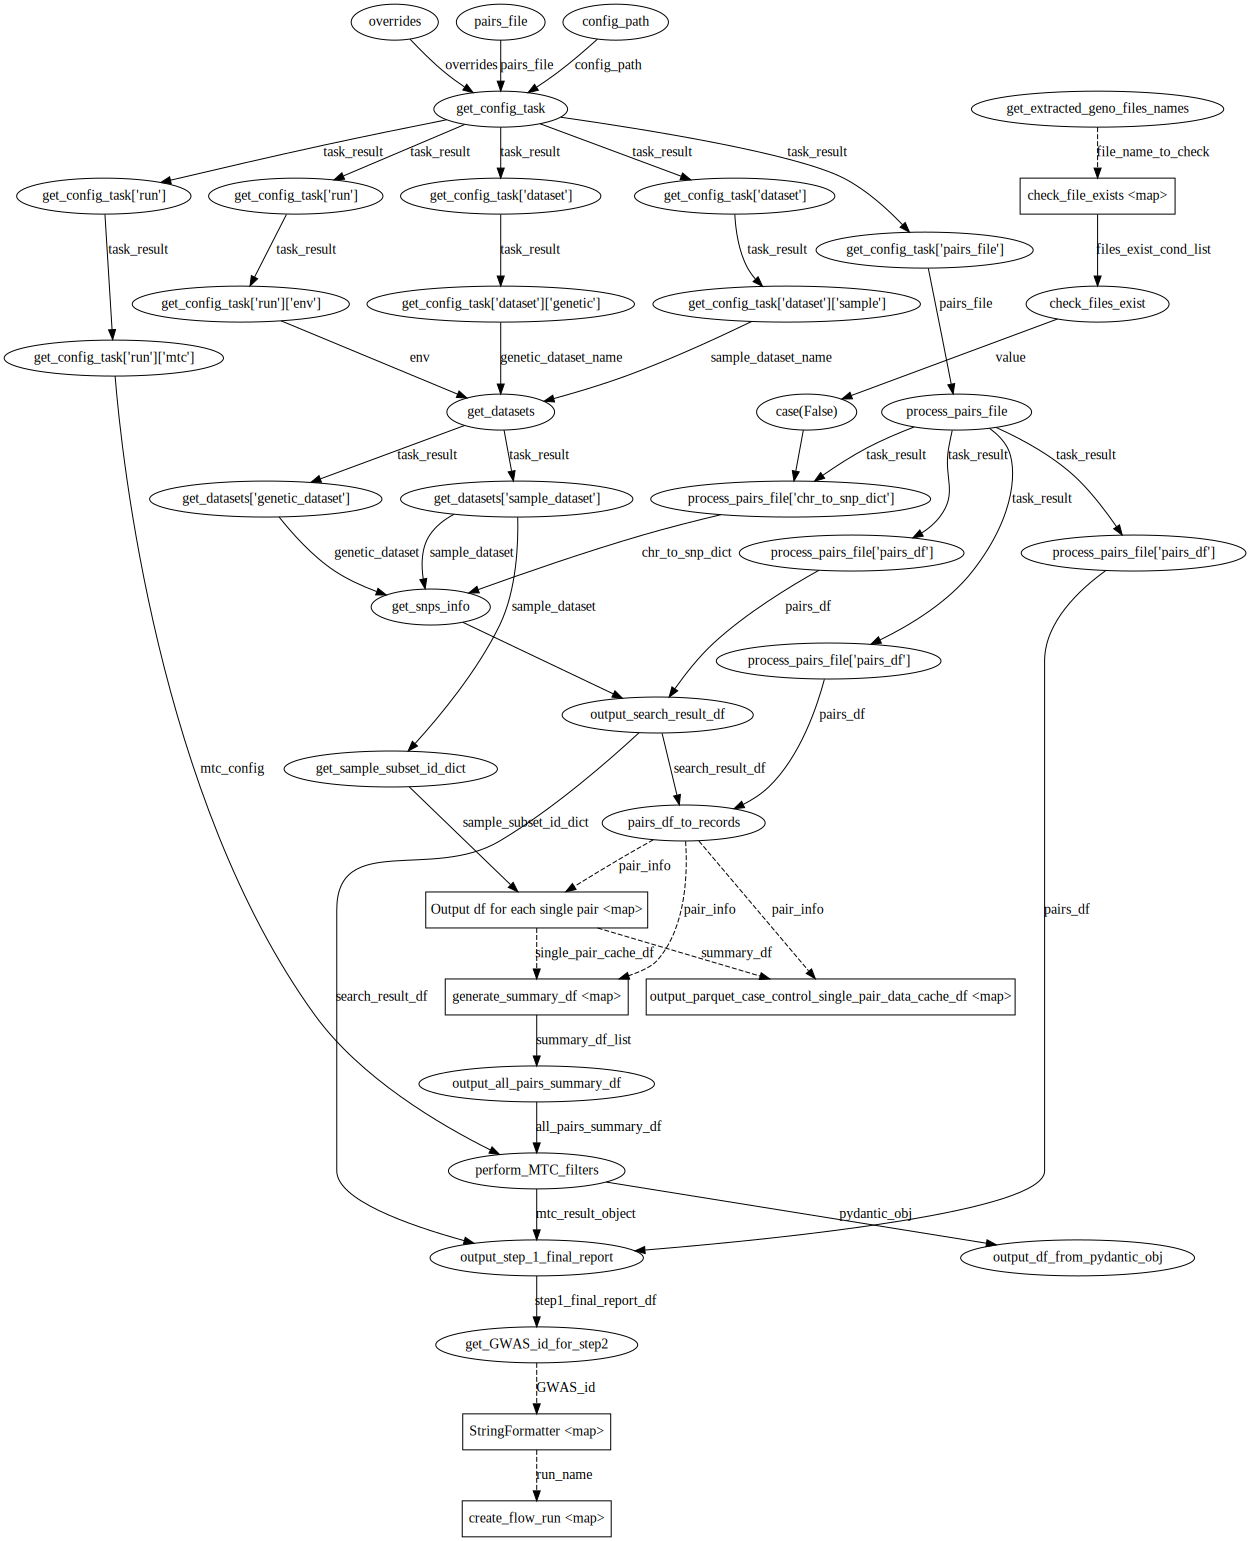

In [74]:
#export

with Flow("OVP_step1") as dev_flow:
    config_path = Parameter("config_path", default = "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/conf/hydra_conf")
    overrides = Parameter("overrides", default = ["exp=test_exp", "dataset=test_MS"])
    pairs_file = Parameter("pairs_file")
    cfg = get_config_task(config_path=config_path, overrides = overrides, pairs_file = pairs_file)#  overrides=overrides, config_name=config_name)
    get_datasets_result = get_datasets(env=cfg["run"]["env"], genetic_dataset_name = cfg["dataset"]["genetic"], sample_dataset_name = cfg["dataset"]["sample"])
    genetic_dataset = get_datasets_result["genetic_dataset"]
    sample_dataset = get_datasets_result["sample_dataset"]
    process_pairs_file_result = process_pairs_file(pairs_file=cfg["pairs_file"])
    extracted_geno_file_names = get_extracted_geno_files_names()
    file_exist_cond_list = check_file_exists.map(extracted_geno_file_names)

    cond = check_files_exist(files_exist_cond_list=file_exist_cond_list, operator=all)

    with case(cond, False):
        get_snps_info_result = get_snps_info(genetic_dataset=genetic_dataset, sample_dataset=sample_dataset, chr_to_snp_dict=process_pairs_file_result["chr_to_snp_dict"])

    pairs_df = process_pairs_file_result["pairs_df"]
    search_result_df = output_search_result_df(pairs_df)
    search_result_df.set_upstream(get_snps_info_result)

    pairs_list = pairs_df_to_records(process_pairs_file_result["pairs_df"], search_result_df)

    sample_subset_id_dict = get_sample_subset_id_dict(sample_dataset)
    output_case_control_single_pair_data_cache_df_result = output_case_control_single_pair_data_cache_df.map(pair_info=pairs_list, sample_subset_id_dict= unmapped(sample_subset_id_dict))
    output_parquet_case_control_single_pair_data_cache_df.map(summary_df = output_case_control_single_pair_data_cache_df_result, pair_info = pairs_list)

    mapped_generate_summary_df_result = generate_summary_df.map(pair_info = pairs_list, single_pair_cache_df = output_case_control_single_pair_data_cache_df_result)
    all_pairs_summary_df = output_all_pairs_summary_df(mapped_generate_summary_df_result)
    mtc_result_object = perform_MTC_filters(all_pairs_summary_df, cfg["run"]["mtc"])
    mtc_object_dict = output_df_from_pydantic_obj(mtc_result_object, exceptions = ())

    report_df = output_step_1_final_report(process_pairs_file_result["pairs_df"], search_result_df, mtc_result_object)

    step2_GWAS_ids = get_GWAS_id_for_step2(report_df)
    step2_flow_run_names = step2_flow_template.map(GWAS_id = step2_GWAS_ids)

    flow_run_ids = create_flow_run.map(flow_name = unmapped("OVP_step2_prod"),
                        project_name = unmapped("ovp"),
                        run_name =  step2_flow_run_names,
                        parameters = unmapped({"step1_folder_path": "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/test_prefect/",
                                                                                                   "total_iterations" : 100,
                                                                                                   "n_iterations": 100}))


dev_flow.visualize()

[2021-12-13 10:06:13-0500] INFO - prefect.FlowRunner | Beginning Flow run for 'OVP_step1'
[2021-12-13 10:06:13-0500] INFO - prefect.TaskRunner | Task 'get_extracted_geno_files_names': Starting task run...
[2021-12-13 10:06:13-0500] INFO - prefect.TaskRunner | Task 'get_extracted_geno_files_names': Finished task run for task with final state: 'Success'
[2021-12-13 10:06:13-0500] INFO - prefect.TaskRunner | Task 'pairs_file': Starting task run...
[2021-12-13 10:06:13-0500] INFO - prefect.TaskRunner | Task 'pairs_file': Finished task run for task with final state: 'Success'
[2021-12-13 10:06:13-0500] INFO - prefect.TaskRunner | Task 'config_path': Starting task run...
[2021-12-13 10:06:13-0500] INFO - prefect.TaskRunner | Task 'config_path': Finished task run for task with final state: 'Success'
[2021-12-13 10:06:14-0500] INFO - prefect.TaskRunner | Task 'check_file_exists': Starting task run...
[2021-12-13 10:06:14-0500] INFO - prefect.TaskRunner | Task 'check_file_exists': Finished task

0it [00:00, ?it/s]

processing last batch


0it [00:00, ?it/s]

Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr1.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr2.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr3.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr4.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr5.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr6.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr7.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr8.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr9.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr10.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr11.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr12.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr13.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr14.gen
Cannot find file data/test_data/gen_file/test_CONTROL_MS_chr15.gen
Cann

0it [00:00, ?it/s]

processing last batch


0it [00:00, ?it/s]

[2021-12-13 10:07:35-0500] INFO - prefect.TaskRunner | Task 'get_snps_info': Finished task run for task with final state: 'Success'
[2021-12-13 10:07:35-0500] INFO - prefect.TaskRunner | Task 'output_search_result_df': Starting task run...
[2021-12-13 10:07:35-0500] INFO - prefect.TaskRunner | Task 'output_search_result_df': Finished task run for task with final state: 'Cached'
[2021-12-13 10:07:35-0500] INFO - prefect.TaskRunner | Task 'pairs_df_to_records': Starting task run...
[2021-12-13 10:07:35-0500] INFO - prefect.TaskRunner | Task 'pairs_df_to_records': Finished task run for task with final state: 'Success'
[2021-12-13 10:07:35-0500] INFO - prefect.TaskRunner | Task 'Output df for each single pair': Starting task run...
[2021-12-13 10:07:35-0500] INFO - prefect.TaskRunner | Task 'Output df for each single pair': Finished task run for task with final state: 'Mapped'
[2021-12-13 10:07:35-0500] INFO - prefect.TaskRunner | Task 'Output df for each single pair[0]': Starting task run

/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/.venv/lib/python3.8/site-packages/prefect/client/client.py:730: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retries = requests.packages.urllib3.util.retry.Retry(


[2021-12-13 10:07:37-0500] INFO - prefect.create_flow_run[0] | Created flow run 'rs134490_GWAS_locus_step2': https://cloud.prefect.io/corradin-lab-mit/flow-run/168ed69b-0c82-4c6f-a0ff-94a101374005
[2021-12-13 10:07:37-0500] INFO - prefect.TaskRunner | Task 'create_flow_run[0]': Finished task run for task with final state: 'Success'
[2021-12-13 10:07:37-0500] INFO - prefect.TaskRunner | Task 'create_flow_run[1]': Starting task run...
[2021-12-13 10:07:37-0500] INFO - prefect.create_flow_run[1] | Creating flow run 'rs5756405_GWAS_locus_step2' for flow 'OVP_step2_prod'...
[2021-12-13 10:07:38-0500] INFO - prefect.create_flow_run[1] | Created flow run 'rs5756405_GWAS_locus_step2': https://cloud.prefect.io/corradin-lab-mit/flow-run/168ed69b-0c82-4c6f-a0ff-94a101374005
[2021-12-13 10:07:38-0500] INFO - prefect.TaskRunner | Task 'create_flow_run[1]': Finished task run for task with final state: 'Success'
[2021-12-13 10:07:38-0500] INFO - prefect.TaskRunner | Task 'create_flow_run[2]': Startin

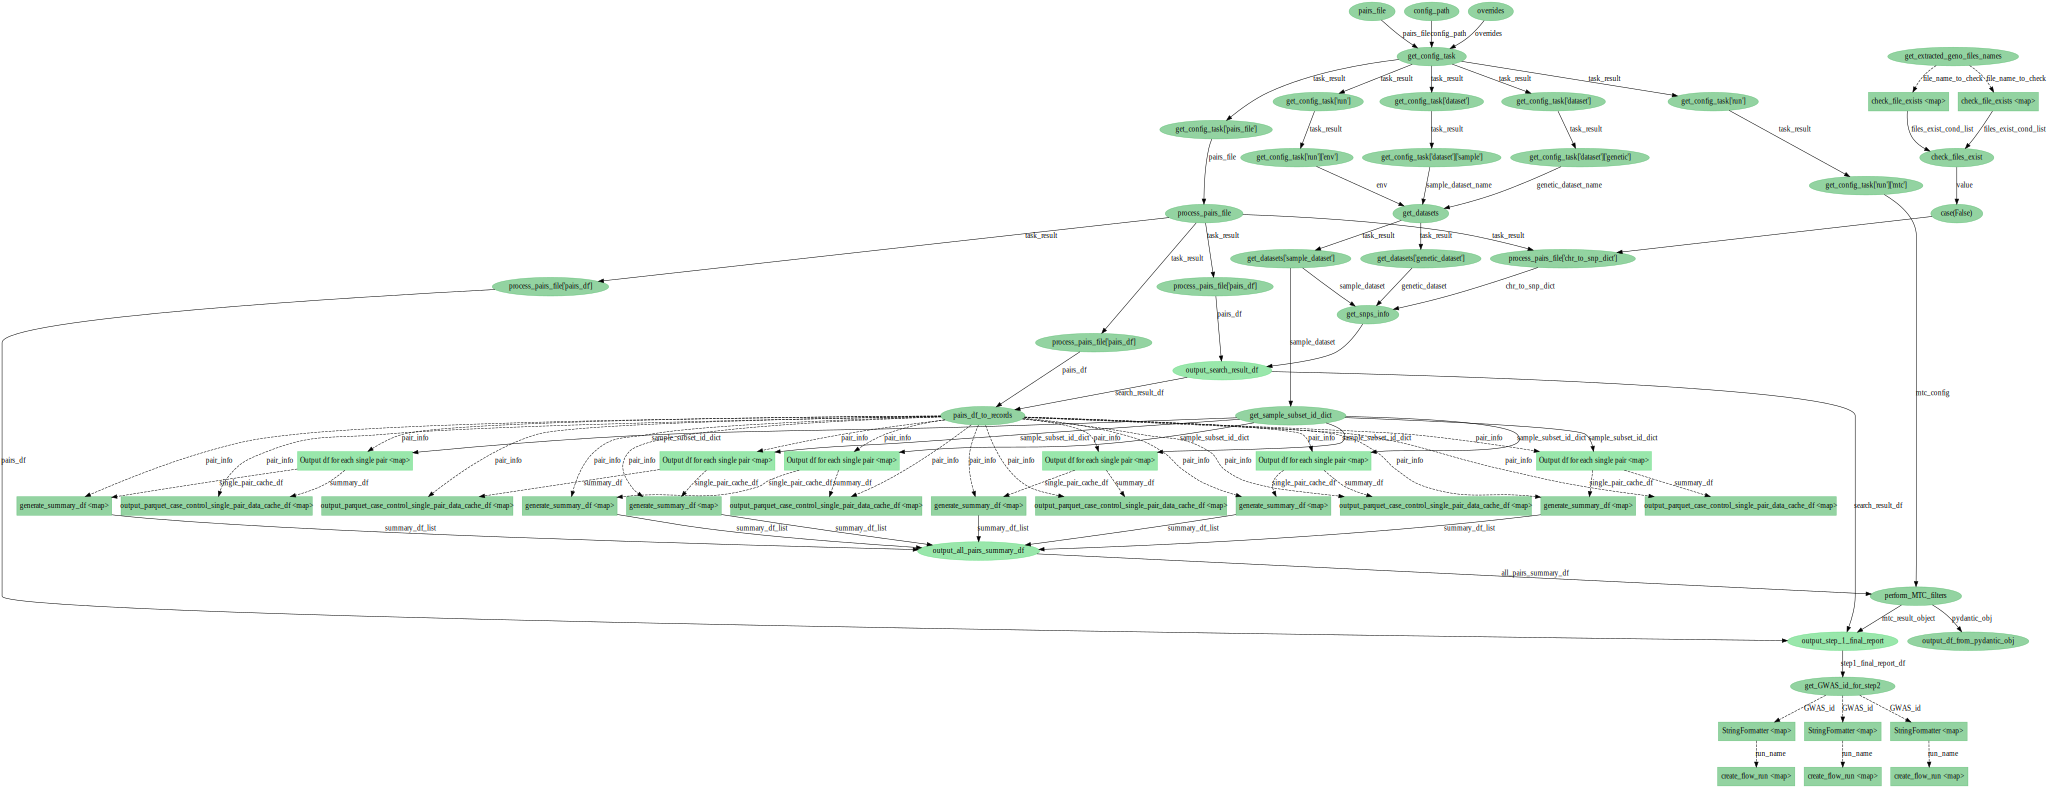

In [14]:
flow_result = dev_flow.run(config_path="conf/hydra_conf/", overrides=["exp=test_exp", "dataset=test_MS"], pairs_file = "test_MS_chr22.tsv")
dev_flow.visualize(flow_state = flow_result)


---

In [5]:
#export

class SNPPairInfo(BaseModel):
    GWAS_id: str
    outside_id: str
    GWAS_chrom: int
    outside_chrom: int
    mtc_threshold: float = None

In [6]:
#export

tsv_result_partial = partialler(LocalResult, dir="./prefect_step1_result_folder", serializer = PandasSerializer("csv",
                                                                         serialize_kwargs={"sep":"\t", "index": False},
                                                                         deserialize_kwargs={"sep": "\t"}))

parquet_result_partial = partialler(LocalResult, dir="./prefect_step1_result_folder", serializer = PandasSerializer("parquet"))
ID_COL_LIST = ["rsid", "position"]
ALL_GENO_DF_FILE_NAME = "all_geno_df.parquet"
ALL_SAMPLES_GENO_DF_FILE_NAME = "all_samples_geno_df.parquet"
SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME = partialler("{subset}_{ALL_SAMPLES_GENO_DF_FILE_NAME}".format, ALL_SAMPLES_GENO_DF_FILE_NAME = ALL_SAMPLES_GENO_DF_FILE_NAME)
SAMPLE_SUBSETS= ["case", "control"]
SEARCH_RESULT_DF_FILE_NAME = "snp_search_result.tsv"
UNFILTERED_SUMMARY_DF_FILE_NAME = "all_pairs_summary_df_unfiltered.tsv"
STEP1_FINAL_REPORT_FILE_NAME = "step1_final_report.tsv"
SINGLE_PAIR_DATA_CACHE_TEMPLATE_WITHOUT_EXTENSION = "snp_pairs_folders/{GWAS_id}/{GWAS_id}_{outside_id}/single_pair_data_cache_df"

def format_result_dir(cfg, task_name, **kwargs):
    return f"{Path(cfg.hydra.run.dir)}/{task_name}"

task_no_checkpoint = partialler(task, checkpoint=False)

@task_no_checkpoint
def get_datasets(*,env:str, genetic_dataset_name:str, sample_dataset_name:str):
    catalog = get_catalog(env=env, patterns = ['catalog*', 'catalog*/*/','catalog*/*/*'])
    genetic =  catalog.load(genetic_dataset_name)
    sample = catalog.load(sample_dataset_name)
    return dict(catalog=catalog, genetic_dataset=genetic, sample_dataset=sample)
    #return catalog, genetic, sample

@task_no_checkpoint
#@task(target= "run_config.pkl")
def get_config_task(*, config_path:str):
    cfg = OmegaConf.load(config_path)
    return cfg


@task_no_checkpoint(skip_on_upstream_skip=False)
def process_pairs_file(*, pairs_file):
    pairs_df = pd.read_csv(pairs_file, sep = "\t")
    GWAS_dict = pairs_df.groupby("GWAS_chrom")["GWAS_id"].unique().to_dict()
    outside_dict = pairs_df.groupby("outside_chrom")["outside_id"].unique().to_dict()
    all_keys = list(GWAS_dict.keys()) + list(outside_dict.keys())
    chr_to_snp_dict = {}
    for key in all_keys:
        GWAS_dict_vals = GWAS_dict.get(key, [])
        outside_dict_vals = outside_dict.get(key, [])
        merged = np.append(GWAS_dict_vals,outside_dict_vals)
        chr_to_snp_dict[key] = merged
    return {"pairs_df": pairs_df, "chr_to_snp_dict": chr_to_snp_dict}

#TODO: Map this across chromosomes
@task_no_checkpoint#(target="{task_name}.pkl", checkpoint=True)
def get_snps_info(*, genetic_dataset, sample_dataset, chr_to_snp_dict):

#     sample_subset_files_list = [SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME(subset = subset) for subset in SAMPLE_SUBSETS]#combined_geno.sample_subsets}

#     file_names_to_check = [ALL_GENO_DF_FILE_NAME, ALL_SAMPLES_GENO_DF_FILE_NAME] + sample_subset_files_list
#     file_exist_cond_list = [parquet_result_partial().exists(location=file_name) for file_name in file_names_to_check]

#     if all(file_exist_cond_list):
#         raise signals.SKIP(message=f"Found existing {ALL_GENO_DF_FILE_NAME} and {ALL_SAMPLES_GENO_DF_FILE_NAME} in {parquet_result_partial().dir}, skipping reading genetic data")
#         return
#     else:

    combined_geno = CombinedGenoPheno.init_from_OVPDataset(genetic_dataset= genetic_dataset,
                                  sample_dataset=sample_dataset,
                                  rsid_dict=chr_to_snp_dict,
                                  id_col_list = ID_COL_LIST)

    #parquet_result.write(combined_geno.all_geno_df, location = all_geno_df_file_name, target = all_geno_df_file_name,  **context,)
    #parquet_result.write(combined_geno.all_samples_geno_df, location = all_samples_geno_df_file_name, target = all_geno_df_file_name, **context)


    parquet_result_partial(location=ALL_GENO_DF_FILE_NAME).write(combined_geno.all_geno_df, **context)
    parquet_result_partial(location=ALL_SAMPLES_GENO_DF_FILE_NAME).write(combined_geno.all_samples_geno_df, **context)

#         sample_subset_files_dict = {SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME(subset = subset) : combined_geno.get_geno_each_sample_subset(subset) for subset in SAMPLE_SUBSETS}

    # for file_name, subset_geno_df in sample_subset_files_dict.items():
    #     parquet_result_partial(location=file_name).write(subset_geno_df, **context)

    return {"all_geno_df":combined_geno.all_geno_df,
            "all_samples_geno_df": combined_geno.all_samples_geno_df}

@task_no_checkpoint(target=SEARCH_RESULT_DF_FILE_NAME, checkpoint=True, result = tsv_result_partial(), skip_on_upstream_skip=False)
def output_search_result_df(pairs_df):
    all_geno_df = parquet_result_partial().read(location=ALL_GENO_DF_FILE_NAME).value
    search_result_df = pd.melt(pairs_df, id_vars=["GWAS_chrom", "outside_chrom"], value_name = "SNP_ID", var_name = "SNP_type").drop_duplicates("SNP_ID")
    search_result_df["chrom"] = np.where(search_result_df["SNP_type"] == "GWAS_id", search_result_df["GWAS_chrom"], search_result_df["outside_chrom"])
    search_result_df = search_result_df.drop(columns = ["GWAS_chrom", "outside_chrom"])
    search_result_df = search_result_df.merge(all_geno_df,
                                left_on = "SNP_ID",
                                right_index=True,
                                how="outer",
                                indicator=True).replace({"both": 1, "left_only": "0"}).rename(columns = {"_merge": "found_in_genetic_file"})[["chrom", "SNP_type", "SNP_ID", "found_in_genetic_file"]]
    return search_result_df

@task_no_checkpoint
def load_extracted_info(*, all_geno_df_file_name:str, search_result_df_file_name:str):
    search_result_df = tsv_result_partial().read(location = SEARCH_RESULT_DF_FILE_NAME).value
    all_geno_df = parquet_result_partial().read(location = ALL_GENO_DF_FILE_NAME)


@task_no_checkpoint#(skip_on_upstream_skip=False)
def pairs_df_to_records(pairs_df, search_result_df=None, mtc_df=None):
    if search_result_df is not None:
        found_SNPs = search_result_df.query("found_in_genetic_file == 1").SNP_ID.tolist()
        found_pairs_df = pairs_df.query("GWAS_id in @found_SNPs and outside_id in @found_SNPs")
    else:
        found_pairs_df = pairs_df

    found_pairs_df = found_pairs_df.drop_duplicates(subset = ["GWAS_id", "outside_id", "GWAS_chrom", "outside_chrom"])

    if mtc_df is not None:
        found_pairs_df = found_pairs_df.merge(mtc_df[["GWAS_id"]], how = "inner")
        mtc_table = MtcTable(mtc_df, "threshold")
        snp_pair_info_list = [SNPPairInfo(**pair, mtc_threshold= mtc_table.get_threshold(pair["GWAS_id"])) for pair in found_pairs_df.to_dict(orient="records")]
    else:
        snp_pair_info_list = [SNPPairInfo(**pair) for pair in found_pairs_df.to_dict(orient="records")]

    return snp_pair_info_list

def template_summary_df_target(*, pair_info: SNPPairInfo, parquet=False, **kwargs):
    GWAS_id = pair_info.GWAS_id
    outside_id = pair_info.outside_id

    if parquet:
        final_template = SINGLE_PAIR_DATA_CACHE_TEMPLATE_WITHOUT_EXTENSION + ".parquet"
    else:
        final_template = SINGLE_PAIR_DATA_CACHE_TEMPLATE_WITHOUT_EXTENSION + ".tsv"

    return final_template.format(GWAS_id = GWAS_id, outside_id = outside_id)

@task_no_checkpoint
def get_sample_subset_id_dict(sample_dataset):
    sample_subset_id_dict = {}
    sample_dataset_files_dict = vars(sample_dataset.files)

    if "single_file" in sample_dataset_files_dict:
        sample_subset_id_dict["case"] = sample_dataset_files_dict["single_file"].load(with_missing_samples=False, subset = "case").index.values.astype(str)
        sample_subset_id_dict["control"] = sample_dataset_files_dict["single_file"].load(with_missing_samples=False, subset = "control").index.values.astype(str)
    else:
        sample_subset_id_dict["case"] = sample_dataset_files_dict["case"].load(with_missing_samples=False).index.values.astype(str)
        sample_subset_id_dict["control"] = sample_dataset_files_dict["control"].load(with_missing_samples=False).index.values.astype(str)

    return sample_subset_id_dict

@task_no_checkpoint(target=template_summary_df_target,
      checkpoint=True,
      result = tsv_result_partial(),
      #skip_on_upstream_skip=False,
      task_run_name = "extract_info_{pair_info.GWAS_id}_{pair_info.outside_id}",
      name = "Output df for each single pair")
#@task(skip_on_upstream_skip=False)
def output_case_control_single_pair_data_cache_df(pair_info, sample_subset_id_dict):
    all_geno_df = parquet_result_partial().read(location=ALL_GENO_DF_FILE_NAME).value

#     if "single_file" in shared_keys:
#         sample_dict_loaded["case"] =  sample_dict[key].load(with_missing_samples = False, subset = "case")
#         sample_dict_loaded["control"] =

    GWAS_id = pair_info.GWAS_id
    outside_id = pair_info.outside_id

    #load only the info of the 2 SNPs
    parquet_column_subset_result = LocalResult(dir="./prefect_step1_result_folder",
                                               serializer = PandasSerializer("parquet", deserialize_kwargs={"columns": [GWAS_id, outside_id]}))

    all_samples_geno_df = parquet_column_subset_result.read(location = ALL_SAMPLES_GENO_DF_FILE_NAME).value

    not_found_case = set(sample_subset_id_dict["case"]) - set(all_samples_geno_df.index)
    not_found_control = set(sample_subset_id_dict["control"]) - set(all_samples_geno_df.index)

    #check to see if the samples in the genetic data are found in the sample file
    #if this assertion is wrong maybe you're rerunning the code on files created from a different dataset than your argument
    assert len(not_found_case) < 100 and len(not_found_control) < 100

    cases_found = sample_subset_id_dict["case"][~np.isin(sample_subset_id_dict["case"], list(not_found_case))]
    controls_found = sample_subset_id_dict["control"][~np.isin(sample_subset_id_dict["control"], list(not_found_control))]

    case_geno_each_sample = all_samples_geno_df.loc[cases_found, :]#parquet_column_subset_result.read(location = SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME(subset="case")).value
    control_geno_each_sample = all_samples_geno_df.loc[controls_found, :]#parquet_column_subset_result.read(location = SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME(subset="control")).value

    summary_df = odds_ratio_df_single_combined(case_geno_each_sample = case_geno_each_sample,
                              control_geno_each_sample = control_geno_each_sample,
                             single_rsid = GWAS_id,
                              all_geno_df = all_geno_df,
                             combo_rsid_list = [GWAS_id, outside_id])

    return summary_df


@task_no_checkpoint
def output_parquet_case_control_single_pair_data_cache_df(summary_df, pair_info, parquet=True):
    file_path = template_summary_df_target(pair_info= pair_info, parquet=True)
    parquet_result_partial(location = file_path).write(summary_df)
    return summary_df

@task_no_checkpoint
def test(val):
    print(val)

In [7]:
#export

@task_no_checkpoint
def get_extracted_geno_files_names():
    #sample_subset_files_list = [SUBSET_ALL_SAMPLES_GENO_DF_FILE_NAME(subset = subset) for subset in SAMPLE_SUBSETS]
    file_names_to_check = [ALL_GENO_DF_FILE_NAME, ALL_SAMPLES_GENO_DF_FILE_NAME] #+ sample_subset_files_list
    return file_names_to_check

@task_no_checkpoint
def check_file_exists(file_name_to_check: str):
    file_exist_cond = parquet_result_partial().exists(location=file_name_to_check) #[parquet_result_partial().exists(location=file_name) for file_name in file_names_to_check]
    return file_exist_cond

@task_no_checkpoint
def check_files_exist(files_exist_cond_list: List[bool], operator):
    return operator(files_exist_cond_list)

@task_no_checkpoint
def output_df_from_pydantic_obj(pydantic_obj, exceptions:List={}):
    filtered_dict = {key: value for key, value in pydantic_obj.dict().items() if (isinstance(value, pd.DataFrame) | (key in exceptions))}
    file_dict = {f"{pydantic_obj.__class__.__name__}/{i}_{key}.tsv": value for (i, (key, value)) in enumerate(filtered_dict.items())}
    for file_path, df in file_dict.items():
        tsv_result_partial(location= file_path).write( df,location= file_path, **context)

    file_names = list(file_dict.keys())

    return file_names

In [8]:
#export

@task_no_checkpoint
def generate_summary_df(single_pair_cache_df, pair_info, include_pairs_info_attrs = {"GWAS_id", "outside_id"}):
    pair_dict = pair_info.dict(include= include_pairs_info_attrs)
    output_df = single_pair_cache_df.copy()
    other_cols = output_df.columns.difference(list(pair_dict.values()) + ["unique_samples_id_case", "unique_samples_id_control"]).tolist() #drop genetic sample data from summary table
    nested_cols_list = [[key, f"{key}_geno"] for key in pair_dict.keys()]
    added_cols = [item for sublist in nested_cols_list for item in sublist]
    output_df["GWAS_chrom"] = pair_info.GWAS_chrom
    output_df["outside_chrom"] = pair_info.outside_chrom
    for (key,val), (var_col, value_col) in zip(pair_dict.items(), nested_cols_list):
        output_df = pd.melt(output_df, id_vars = output_df.columns.difference([val]), var_name=var_col, value_name=value_col)

    output_df = output_df[added_cols + other_cols] #output_df[added_cols + list(exclude_pair_info_attrs) + other_cols]
    return output_df

In [9]:
#export

@task(target=UNFILTERED_SUMMARY_DF_FILE_NAME, result = tsv_result_partial())
def output_all_pairs_summary_df(summary_df_list):
    all_pairs_summary_df = pd.concat(summary_df_list).sort_values(by=["GWAS_id", "outside_id", "GWAS_id_geno", "outside_id_geno"])
    return all_pairs_summary_df

In [10]:
#export

@task_no_checkpoint
def perform_MTC_filters(all_pairs_summary_df, mtc_config):
    mtc_result_object = MtcTable.create_mtc_table_from_summary_df(all_pairs_summary_df,
                                                                  filter_1_queries=mtc_config["filter_1_queries"],
                                                                  filter_2_queries= mtc_config["filter_2_queries"])
    return mtc_result_object

In [11]:
#export

@task(target=STEP1_FINAL_REPORT_FILE_NAME, result = tsv_result_partial())
def output_step_1_final_report(pairs_df, search_result_df, mtc_result_object):

    report_df = pairs_df.merge(search_result_df[["SNP_ID", "found_in_genetic_file"]], left_on = "GWAS_id", right_on="SNP_ID", how = "left")\
    .merge(search_result_df[["SNP_ID", "found_in_genetic_file"]], left_on = "outside_id", right_on="SNP_ID", how = "left", suffixes=["_GWAS", "_outside"])
    report_df = report_df[["GWAS_id", "outside_id", "GWAS_chrom", "outside_chrom", "found_in_genetic_file_GWAS", "found_in_genetic_file_outside"]]

    final_test_report_df = report_df.merge(mtc_result_object.original_summary_df, how= "outer", indicator = "all_SNPs_found_in_genetic_file")\
    .merge(mtc_result_object.non_zero_geno_combos_pass_cond, how="outer", indicator="geno_combo_passed_filter_1")\
    .merge(mtc_result_object.filter_1, how="outer", indicator="pair_has_enough_geno_combo_passed_filter_1")\
    .merge(mtc_result_object.filter_2, how="outer", indicator="geno_combo_passed_filter_2").replace({"left_only":0, "both": 1}).fillna("NA")

    return final_test_report_df

In [12]:
#export

@task_no_checkpoint
def get_GWAS_id_for_step2(step1_final_report_df):
    df = step1_final_report_df.query("geno_combo_passed_filter_2 == 1")
    df = df.drop_duplicates(["GWAS_id"])
    return df.GWAS_id.tolist()

step2_flow_template = StringFormatter(template = "{GWAS_id}_GWAS_locus_step2")

@task_no_checkpoint
def dummy_task(data):
    return data

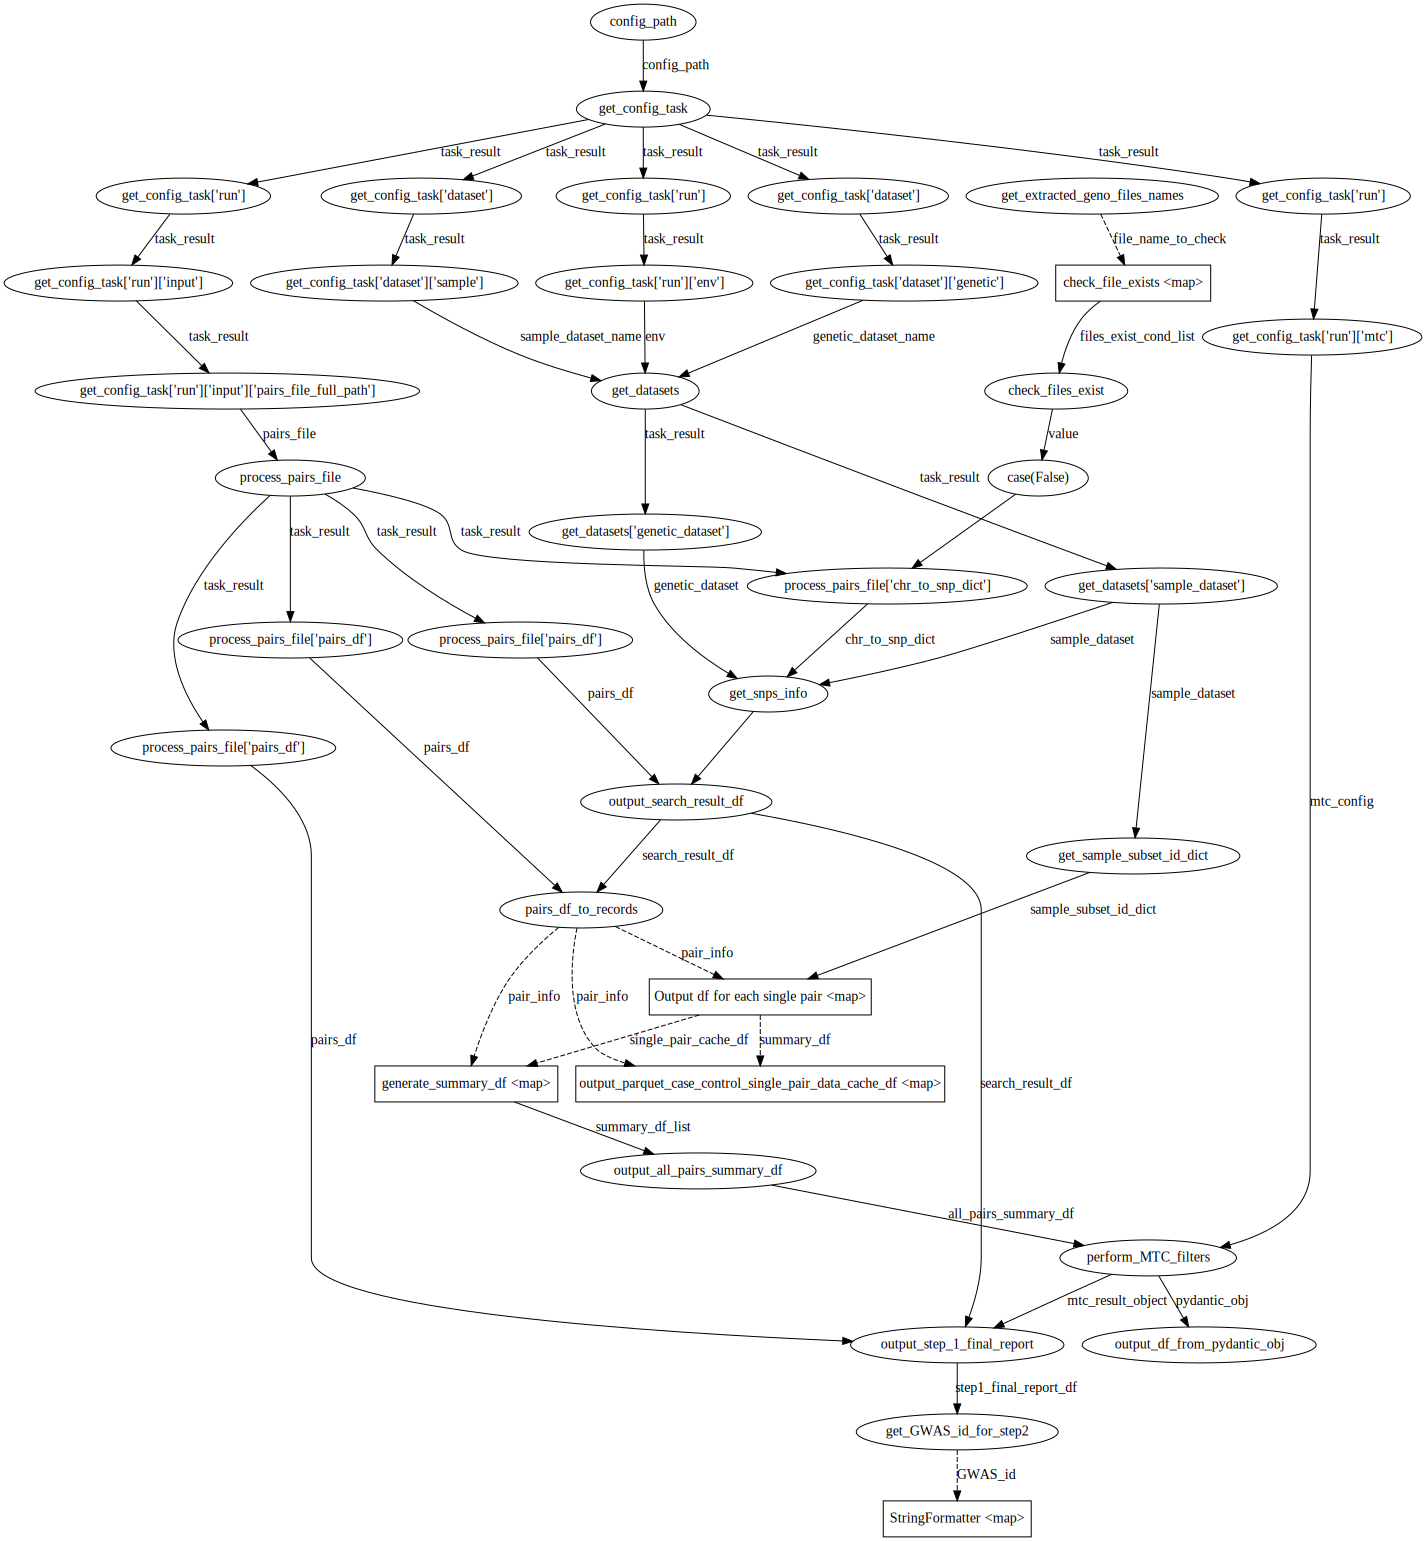

In [13]:
#export

DEFAULT_CONFIG_PATH = "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/corradin_ovp_utils/conf/example_prefect_step1_filled_conf.yaml"

with Flow("OVP_step1_hydra") as step1_flow_hydra:
    config_path = Parameter("config_path", default = DEFAULT_CONFIG_PATH)
    # overrides = Parameter("overrides", default = ["exp=test_exp", "dataset=test_MS"])
    # pairs_file = Parameter("pairs_file")
    cfg = get_config_task(config_path=config_path)#, overrides = overrides, pairs_file = pairs_file)#  overrides=overrides, config_name=config_name)
    get_datasets_result = get_datasets(env=cfg["run"]["env"], genetic_dataset_name = cfg["dataset"]["genetic"], sample_dataset_name = cfg["dataset"]["sample"])
    genetic_dataset = get_datasets_result["genetic_dataset"]
    sample_dataset = get_datasets_result["sample_dataset"]
    process_pairs_file_result = process_pairs_file(pairs_file=cfg["run"]["input"]["pairs_file_full_path"])
    extracted_geno_file_names = get_extracted_geno_files_names()
    file_exist_cond_list = check_file_exists.map(extracted_geno_file_names)

    cond = check_files_exist(files_exist_cond_list=file_exist_cond_list, operator=all)

    with case(cond, False):
        get_snps_info_result = get_snps_info(genetic_dataset=genetic_dataset, sample_dataset=sample_dataset, chr_to_snp_dict=process_pairs_file_result["chr_to_snp_dict"])

    pairs_df = process_pairs_file_result["pairs_df"]
    search_result_df = output_search_result_df(pairs_df)
    search_result_df.set_upstream(get_snps_info_result)

    pairs_list = pairs_df_to_records(process_pairs_file_result["pairs_df"], search_result_df)

    sample_subset_id_dict = get_sample_subset_id_dict(sample_dataset)
    output_case_control_single_pair_data_cache_df_result = output_case_control_single_pair_data_cache_df.map(pair_info=pairs_list, sample_subset_id_dict= unmapped(sample_subset_id_dict))
    output_parquet_case_control_single_pair_data_cache_df.map(summary_df = output_case_control_single_pair_data_cache_df_result, pair_info = pairs_list)

    mapped_generate_summary_df_result = generate_summary_df.map(pair_info = pairs_list, single_pair_cache_df = output_case_control_single_pair_data_cache_df_result)
    all_pairs_summary_df = output_all_pairs_summary_df(mapped_generate_summary_df_result)
    mtc_result_object = perform_MTC_filters(all_pairs_summary_df, cfg["run"]["mtc"])
    mtc_object_dict = output_df_from_pydantic_obj(mtc_result_object, exceptions = ())

    report_df = output_step_1_final_report(process_pairs_file_result["pairs_df"], search_result_df, mtc_result_object)

    step2_GWAS_ids = get_GWAS_id_for_step2(report_df)
    step2_flow_run_names = step2_flow_template.map(GWAS_id = step2_GWAS_ids)

#     flow_run_ids = create_flow_run.map(flow_name = unmapped("OVP_step2_prod"),
#                         project_name = unmapped("ovp"),
#                         run_name =  step2_flow_run_names,
#                         parameters = unmapped({"step1_folder_path": "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/test_prefect/",
#                                                                                                    "total_iterations" : 100,
#                                                                                                    "n_iterations": 100}))


step1_flow_hydra.visualize()

In [14]:
# test_result_folder = "./test_prefect_step1/inner_folder"
# os.makedirs(test_result_folder,exist_ok=True)

# with cd(test_result_folder):
#     flow_hydra_result = flow_hydra.run(config_path="conf/hydra_conf/", overrides=["exp=test_exp", "dataset=test_MS"], pairs_file = "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/test_MS_chr22.tsv")#(config_path=DEFAULT_CONFIG_PATH)
# flow_hydra.visualize(flow_state=flow_hydra_result)

flow_hydra_result = step1_flow_hydra.run(config_path=DEFAULT_CONFIG_PATH)#(config_path=DEFAULT_CONFIG_PATH)

[2021-12-13 15:06:39-0500] INFO - prefect.FlowRunner | Beginning Flow run for 'OVP_step1_hydra'
[2021-12-13 15:06:39-0500] INFO - prefect.TaskRunner | Task 'get_extracted_geno_files_names': Starting task run...
[2021-12-13 15:06:39-0500] INFO - prefect.TaskRunner | Task 'get_extracted_geno_files_names': Finished task run for task with final state: 'Success'
[2021-12-13 15:06:39-0500] INFO - prefect.TaskRunner | Task 'config_path': Starting task run...
[2021-12-13 15:06:39-0500] INFO - prefect.TaskRunner | Task 'config_path': Finished task run for task with final state: 'Success'
[2021-12-13 15:06:39-0500] INFO - prefect.TaskRunner | Task 'check_file_exists': Starting task run...
[2021-12-13 15:06:39-0500] INFO - prefect.TaskRunner | Task 'check_file_exists': Finished task run for task with final state: 'Mapped'
[2021-12-13 15:06:39-0500] INFO - prefect.TaskRunner | Task 'check_file_exists[0]': Starting task run...
[2021-12-13 15:06:39-0500] INFO - prefect.TaskRunner | Task 'check_file_

In [15]:
get_datasets.run(env="cluster", genetic_dataset_name="UKB_genetic_file_bgen_split_by_chrom", sample_dataset_name='UKB_sample_file_with_pheno_col')["catalog"].reload().list()

['MS_genetic_file_split_by_chrom',
 'MS_sample_file',
 'UKB_genetic_file_bgen_split_by_chrom',
 'UKB_sample_file_basic_March_27_2021',
 'test_UKB_sample_file_with_pheno_col',
 'UKB_sample_file_with_pheno_col',
 'UKB_sample_file_risk_taking',
 'test_MS_genetic_file_split_by_chrom',
 'genetic_file_bgen',
 'test_MS_sample_file']

[2021-12-13 11:29:15-0500] INFO - prefect.FlowRunner | Beginning Flow run for 'OVP_step1_hydra'
[2021-12-13 11:29:15-0500] INFO - prefect.TaskRunner | Task 'config_path': Starting task run...
[2021-12-13 11:29:15-0500] INFO - prefect.TaskRunner | Task 'config_path': Finished task run for task with final state: 'Success'
[2021-12-13 11:29:15-0500] INFO - prefect.TaskRunner | Task 'get_extracted_geno_files_names': Starting task run...
[2021-12-13 11:29:15-0500] INFO - prefect.TaskRunner | Task 'get_extracted_geno_files_names': Finished task run for task with final state: 'Success'
[2021-12-13 11:29:15-0500] INFO - prefect.TaskRunner | Task 'check_file_exists': Starting task run...
[2021-12-13 11:29:15-0500] INFO - prefect.TaskRunner | Task 'check_file_exists': Finished task run for task with final state: 'Mapped'
[2021-12-13 11:29:15-0500] INFO - prefect.TaskRunner | Task 'check_file_exists[0]': Starting task run...
[2021-12-13 11:29:15-0500] INFO - prefect.TaskRunner | Task 'check_file_

0it [00:00, ?it/s]

processing last batch


0it [00:00, ?it/s]

Cannot find file /lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/data/test_data/gen_file/test_CONTROL_MS_chr1.gen
Cannot find file /lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/data/test_data/gen_file/test_CONTROL_MS_chr2.gen
Cannot find file /lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/data/test_data/gen_file/test_CONTROL_MS_chr3.gen
Cannot find file /lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/data/test_data/gen_file/test_CONTROL_MS_chr4.gen
Cannot find file /lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/data/test_data/gen_file/test_CONTROL_MS_chr5.gen
Cannot find file /lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/data/test_data/gen_file/test_CONTROL_MS_chr6.gen
Cannot find file /lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/data/test_data/gen_file/test_CONTROL_MS_chr7.gen
Cannot find file /lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/data/test_data/gen_file/test_CONTROL_MS_chr8.gen
Cannot find file /lab/corradin_biobank/FOR_AN/OVP/corrad

0it [00:00, ?it/s]

processing last batch


0it [00:00, ?it/s]

[2021-12-13 11:30:36-0500] INFO - prefect.TaskRunner | Task 'get_snps_info': Finished task run for task with final state: 'Success'
[2021-12-13 11:30:36-0500] INFO - prefect.TaskRunner | Task 'output_search_result_df': Starting task run...
[2021-12-13 11:30:36-0500] INFO - prefect.TaskRunner | Task 'output_search_result_df': Finished task run for task with final state: 'Cached'
[2021-12-13 11:30:36-0500] INFO - prefect.TaskRunner | Task 'pairs_df_to_records': Starting task run...
[2021-12-13 11:30:36-0500] INFO - prefect.TaskRunner | Task 'pairs_df_to_records': Finished task run for task with final state: 'Success'
[2021-12-13 11:30:36-0500] INFO - prefect.TaskRunner | Task 'Output df for each single pair': Starting task run...
[2021-12-13 11:30:36-0500] INFO - prefect.TaskRunner | Task 'Output df for each single pair': Finished task run for task with final state: 'Mapped'
[2021-12-13 11:30:36-0500] INFO - prefect.TaskRunner | Task 'Output df for each single pair[0]': Starting task run

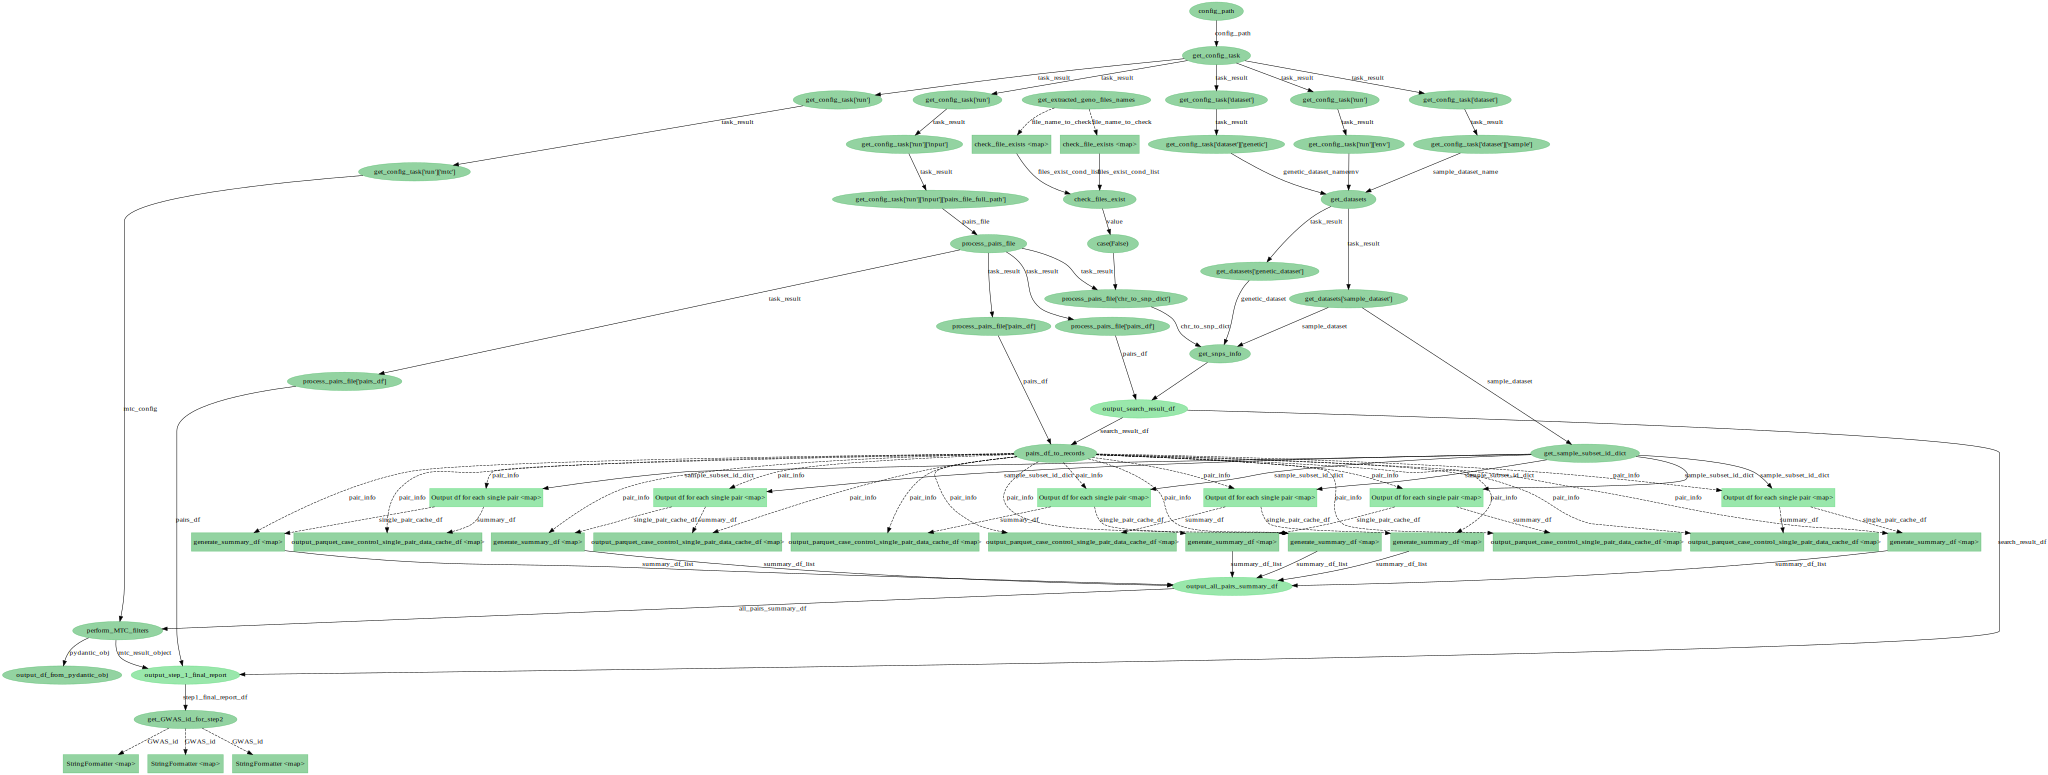

In [51]:
#test in different directory. This screws up everything but helpful to know what paths/files need to provide full path

test_result_folder = "./test_prefect_step1/inner_folder"
os.makedirs(test_result_folder,exist_ok=True)

with cd(test_result_folder):
    flow_hydra_different_dir_result = flow_hydra.run(config_path=DEFAULT_CONFIG_PATH)
    
flow_hydra.visualize(flow_state=flow_hydra_different_dir_result)